# TP53 benchmarking with training cohort data

#### TP53 experimental assay from Kotler E, Shani O, Goldfeld G, Lotan-Pompan M, Tarcic O, Gershoni A, et al. A systematic p53 mutation library links differential functional impact to cancer mutation pattern and evolutionary conservation. Mol Cell 2018;71:178–90.e8.

### 1. Upload data
### 2. Generate crossvalidation data
### 3. Precision recall curves
### 4. F50 score and performance

# 1. Upload data

In [2]:
import pandas as pd
import numpy as np
import os
from io import StringIO
from scipy.stats import fisher_exact
import copy
import gzip
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)
import matplotlib.pyplot as plt
import collections

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [3]:
TP53_Kotler = pd.read_csv('../../../Paper_data/Experimental_data/TP53/bench_TP53_Kotler.csv', sep='\t')
# Remove cases with two mutations
TP53_Kotler = TP53_Kotler[TP53_Kotler['Sec_mut_position'].isna()]
# Remove indels
remove = ['Ins', 'Del', 'IARC.InDel.GeneVars', 'DelAA', 'Del2AA',
         'Sub2bp', 'IARC.InDel.SomatMuts', 'wtp53_DBDA_seq', 'wtp53_DBDB_seq',
         'wtp53_DBDC_seq', 'wtp53_DBDD_seq', 'IARC.InDel.GermLine']
TP53_Kotler = TP53_Kotler[~TP53_Kotler['Mut_type'].isin(remove)]
TP53_Kotler['aachange'] = TP53_Kotler['AA_change'].str[0]+TP53_Kotler['Codon_num'].astype(str).str[:-2]+TP53_Kotler['AA_change'].str[-1]
TP53_Kotler

,Number,Var_seq,Identifier,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Sec_mut_position,Sec_seq_change,Sec_codon_num,Sec_AA_change,MutID,IARC_Desc,Silent,RFS_H1299,aachange
0,1,AAATACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100001,DBDA,wt,AASub,304,ACC>AAA,102.0,T>K,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.224744,T102K
1,2,AGATACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100002,DBDA,wt,AASub,304,ACC>AGA,102.0,T>R,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.973493,T102R
2,3,ATGTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100003,DBDA,wt,AASub,304,ACC>ATG,102.0,T>M,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-3.400709,T102M
3,4,CACTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100004,DBDA,wt,AASub,304,ACC>CAC,102.0,T>H,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.277664,T102H
4,5,CTCTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100005,DBDA,wt,AASub,304,ACC>CTC,102.0,T>L,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.486801,T102L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9506,9821,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403439,DBDD,wt,Sub,875,A>C,292.0,K>T,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-1.786279,K292T
9507,9822,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403440,DBDD,wt,Sub,875,A>G,292.0,K>R,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.140749,K292R
9508,9823,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403441,DBDD,wt,Sub,875,A>T,292.0,K>I,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-1.771565,K292I
9512,9827,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403445,DBDD,wt,Sub,876,A>C,292.0,K>N,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-1.443976,K292N


In [4]:
# Upload the TP53 boostDM-CH predictions
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'TP53.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
gene_model

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,ID
0,TP53,ENST00000269305,ENSG00000141510,17,7669612,A,D393D,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,CH,0.000906,False,-0.024345,0.0,-2.079028,-0.155365,-0.428166,0.0,0.000016,0.001413,0.003593,0.000654,-0.000315,0.084412,-0.161530,-0.167058,-0.134467,7669612A
1,TP53,ENST00000269305,ENSG00000141510,17,7669612,C,D393E,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000801,False,-0.024866,0.0,-2.167131,-0.112915,-0.444743,0.0,0.000016,0.001717,0.003768,0.000692,-0.000336,-0.053726,-0.161603,-0.165962,0.011377,7669612C
2,TP53,ENST00000269305,ENSG00000141510,17,7669612,T,D393E,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000801,False,-0.024866,0.0,-2.167131,-0.112915,-0.444743,0.0,0.000016,0.001717,0.003768,0.000692,-0.000336,-0.053726,-0.161603,-0.165962,0.011377,7669612T
3,TP53,ENST00000269305,ENSG00000141510,17,7669613,A,D393V,0.0,0,0,0,3.425781,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002309,False,-0.022500,0.0,-1.960687,-0.067766,-0.258042,0.0,0.000019,0.000353,0.003853,0.000693,-0.000351,-0.049602,-0.146028,-0.163720,0.011061,7669613A
4,TP53,ENST00000269305,ENSG00000141510,17,7669613,C,D393G,0.0,0,0,0,3.425781,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002309,False,-0.022500,0.0,-1.960687,-0.067766,-0.258042,0.0,0.000019,0.000353,0.003853,0.000693,-0.000351,-0.049602,-0.146028,-0.163720,0.011061,7669613C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,TP53,ENST00000269305,ENSG00000141510,17,7676590,C,E2G,0.0,0,0,0,1.806641,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000816,False,-0.024763,0.0,-2.191683,-0.115753,-0.410044,0.0,0.000016,0.002003,0.003799,0.000700,-0.000335,-0.053798,-0.161667,-0.165514,0.011389,7676590C
3524,TP53,ENST00000269305,ENSG00000141510,17,7676590,G,E2A,0.0,0,0,0,1.806641,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000816,False,-0.024763,0.0,-2.191683,-0.115753,-0.410044,0.0,0.000016,0.002003,0.003799,0.000700,-0.000335,-0.053798,-0.161667,-0.165514,0.011389,7676590G
3525,TP53,ENST00000269305,ENSG00000141510,17,7676591,A,E2*,0.0,0,0,0,1.867188,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.278992,False,-0.021575,0.0,-1.464270,-0.137871,-0.280289,0.0,0.000017,0.003097,0.003966,0.000844,-0.000301,0.115021,1.443173,-0.113238,0.024430,7676591A
3526,TP53,ENST00000269305,ENSG00000141510,17,7676591,G,E2Q,0.0,0,0,0,1.867188,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000805,False,-0.024914,0.0,-2.186374,-0.114942,-0.421961,0.0,0.000016,0.001890,0.003784,0.000697,-0.000335,-0.053775,-0.161638,-0.165528,0.011382,7676591G


# 2. Generate crossvalidation data

In [7]:
### Open file crossvalidation
file_path = '../../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/TP53_crossvalidation_50iterations_V2.txt'
gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)

### Calculate boostDM prediction 0/1
gene_crossval['boostDM_predic'] = gene_crossval['boostDM_score'].apply(lambda x: 1 if x>=0.5 else 0)

### Merge with boostDM prediction output to have the annotation of protein position
# Get saturation mutagenesis prediction
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'TP53.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
# Merge
gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange']],
                              gene_crossval,
                              on=['chr', 'pos', 'alt'], how='right')
# Eliminate intronic/splicing rows
gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)

print(len(gene_crossval_info))

# Create dataframe for the predictions
gene_crossval_harv = gene_crossval_info
gene_crossval_harv['row'] = gene_crossval_harv.index   
gene_crossval_harv['ID'] = gene_crossval_harv['pos'].astype(str)+gene_crossval_harv['alt']

gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['ID'].isin(gene_model['ID'])]
gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['aachange'].isin(TP53_Kotler['aachange'])]
gene_crossval_harv['Kotler'] = gene_crossval_harv['aachange'].apply(lambda x:TP53_Kotler[TP53_Kotler['aachange']==x]['RFS_H1299'].iloc[0])
gene_crossval_harv

5653


,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Kotler
0,TP53,17,7675171,G,V147V,0.0000,0,0,0,-0.086975,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,A,0,0.021922,0,0,0,7675171G,-2.733120
1,TP53,17,7674879,T,V218M,0.0000,0,0,1,4.003906,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0,0.048858,0,0,1,7674879T,-1.851503
2,TP53,17,7674220,T,R248Q,0.0000,0,1,1,6.164062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.917398,0,1,2,7674220T,-0.039587
4,TP53,17,7673790,T,C277Y,513.7234,1,1,1,6.082031,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.901973,0,1,4,7673790T,-1.714101
5,TP53,17,7674229,T,G245D,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.804838,0,1,5,7674229T,0.288449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5647,TP53,17,7674948,A,I195F,0.0000,0,1,1,8.015625,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,T,1,0.860127,49,1,5647,7674948A,0.239306
5648,TP53,17,7673779,T,D281N,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.831586,49,1,5648,7673779T,-0.002384
5649,TP53,17,7675082,T,P177H,0.0000,0,1,1,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1,0.822115,49,1,5649,7675082T,-1.769799
5651,TP53,17,7675097,T,V172D,0.0000,0,1,1,9.328125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,A,1,0.794037,49,1,5651,7675097T,0.478359


In [8]:
gene_crossval_harv['driver'].value_counts()

1    2587
0    1502
Name: driver, dtype: int64

In [9]:
gene_crossval_harv_equal = pd.DataFrame(columns=gene_crossval_harv.columns.tolist())

for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    gene_crossval_harv_equal = pd.concat([gene_crossval_harv_equal, gene_crossval_harv_equal_i])
gene_crossval_harv_equal.reset_index(drop=True, inplace=True)
gene_crossval_harv_equal['driver'] = gene_crossval_harv_equal['driver'].astype(float)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Kotler
0,TP53,17,7674252,T,M237I,0.0000,0,1,1,7.828125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.816253,0,1,31,7674252T,0.470694
1,TP53,17,7675185,T,V143M,0.0000,0,1,1,1.255859,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.688286,0,1,77,7675185T,-1.330712
2,TP53,17,7676010,A,K120M,0.0000,0,1,1,6.449219,0,1.0,0.0,0.0,1.0,1.0,1,0,0,0,T,1.0,0.957425,0,1,86,7676010A,-1.591743
3,TP53,17,7674221,A,R248W,0.0000,0,1,1,0.834961,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.747464,0,1,23,7674221A,0.073975
4,TP53,17,7673787,A,P278L,513.7234,1,1,1,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.794637,0,1,79,7673787A,0.545162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,TP53,17,7676054,T,G105G,0.0000,0,0,0,-0.075989,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,G,0.0,0.020795,49,0,5638,7676054T,-2.540000
3000,TP53,17,7675995,T,T125K,0.0000,0,0,1,8.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.147234,49,0,5639,7675995T,-0.489939
3001,TP53,17,7673822,C,G266G,0.0000,0,0,0,-1.391602,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,T,0.0,0.025101,49,0,5642,7673822C,-1.886507
3002,TP53,17,7675070,T,R181H,0.0000,0,0,1,0.789062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.048070,49,0,5643,7675070T,-2.110078


In [10]:
gene_crossval_harv_equal['driver'].value_counts()

1.0    1502
0.0    1502
Name: driver, dtype: int64

# 3. Precision recall curves

In [11]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['driver'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

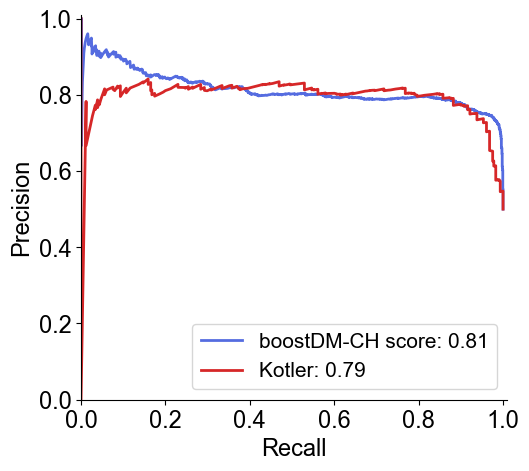

In [12]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(gene_crossval_harv_equal, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(gene_crossval_harv_equal, 'Kotler', ax=ax, color='#d62728', lw=2, alpha=1)
gene_crossval_harv_equal['prob_Kotler'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'Kotler: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [13]:
gene_crossval_harv_equal['cat_Kotler'] = gene_crossval_harv_equal['prob_Kotler'].apply(lambda x:1 if x >=0.5 else 0)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Kotler,prob_Kotler,cat_Kotler
0,TP53,17,7674252,T,M237I,0.0000,0,1,1,7.828125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.816253,0,1,31,7674252T,0.470694,0.878055,1
1,TP53,17,7675185,T,V143M,0.0000,0,1,1,1.255859,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.688286,0,1,77,7675185T,-1.330712,0.334600,0
2,TP53,17,7676010,A,K120M,0.0000,0,1,1,6.449219,0,1.0,0.0,0.0,1.0,1.0,1,0,0,0,T,1.0,0.957425,0,1,86,7676010A,-1.591743,0.254808,0
3,TP53,17,7674221,A,R248W,0.0000,0,1,1,0.834961,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.747464,0,1,23,7674221A,0.073975,0.800270,1
4,TP53,17,7673787,A,P278L,513.7234,1,1,1,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.794637,0,1,79,7673787A,0.545162,0.889355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,TP53,17,7676054,T,G105G,0.0000,0,0,0,-0.075989,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,G,0.0,0.020795,49,0,5638,7676054T,-2.540000,0.077687,0
3000,TP53,17,7675995,T,T125K,0.0000,0,0,1,8.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.147234,49,0,5639,7675995T,-0.489939,0.635248,1
3001,TP53,17,7673822,C,G266G,0.0000,0,0,0,-1.391602,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,T,0.0,0.025101,49,0,5642,7673822C,-1.886507,0.181139,0
3002,TP53,17,7675070,T,R181H,0.0000,0,0,1,0.789062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.048070,49,0,5643,7675070T,-2.110078,0.137172,0


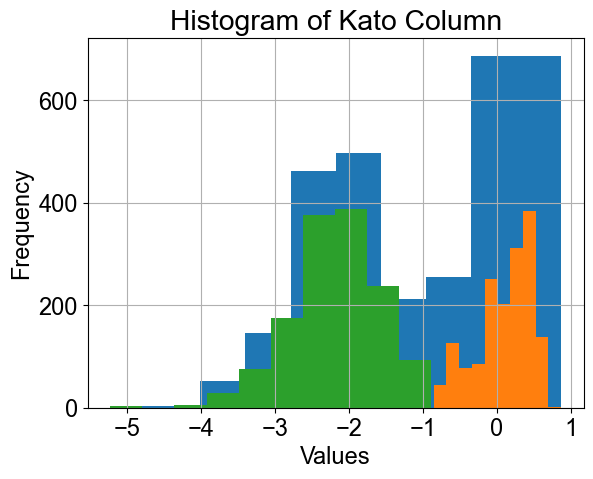

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming gene_crossval_harv_equal is your DataFrame

# Plot the histogram for the 'Kato' column
gene_crossval_harv_equal['Kotler'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Kotler']==1]['Kotler'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Kotler']==0]['Kotler'].hist()


# Add labels and title to the plot (optional)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Kato Column')

# Display the plot
plt.show()

In [15]:
# Where does the limit be stablished
gene_crossval_harv_equal[gene_crossval_harv_equal['prob_Kotler']<0.5]['Kotler'].max()

-0.883296341

# 4. F50 score and performance

In [16]:
### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

In [17]:
### Define function to calculate specific statistic

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['driver']==1) & (data[method]==1)])
    tn = len(data[(data['driver']==0) & (data[method]==0)])
    fp = len(data[(data['driver']==0) & (data[method]==1)])
    fn = len(data[(data['driver']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [18]:
#Analysis

eval_boostdm = []
eval_Kotler = []

#make same random
for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv_equal[gene_crossval_harv_equal['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    
    ## Calculate all statistics for each method
    for method in ['boostDM_predic', 'cat_Kotler']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']: 
            # Calculate statistic
            statistics.append(quality_statistic(gene_crossval_harv_equal_i, method=method, statistic=statistic))
        if method == 'boostDM_predic': eval_boostdm.append(statistics)
        elif method == 'cat_Kotler': eval_Kotler.append(statistics)


In [19]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'Kotler': pd.DataFrame(eval_Kotler).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Kotler_Q1': pd.DataFrame(eval_Kotler).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Kotler_Q3': pd.DataFrame(eval_Kotler).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,Kotler,BoostDM_Q1,BoostDM_Q3,Kotler_Q1,Kotler_Q3
0,$F_{50}$,0.790481,0.806318,0.761571,0.809638,0.781516,0.835962
1,F1,0.837852,0.824278,0.815058,0.857143,0.801493,0.846861
2,Accuracy,0.818907,0.817013,0.789983,0.842143,0.791816,0.846041
3,Precision,0.762274,0.795247,0.730631,0.786855,0.765196,0.839459
4,Recall,0.934376,0.858455,0.897414,0.968750,0.818182,0.900634
5,NPV,0.920492,0.848285,0.872762,0.957880,0.810811,0.888889


In [20]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)
plot_data

,Statistic,BoostDM,Kotler
0,$F_{50}$,0.790481,0.806318
1,Precision,0.762274,0.795247
2,Recall,0.934376,0.858455


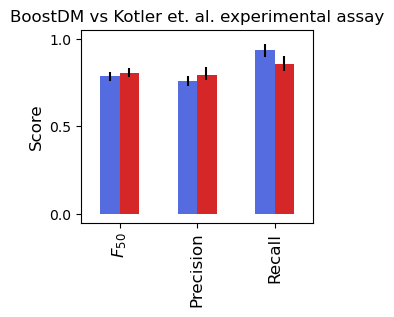

In [21]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic',\
                                                                                      figsize=(3,2.5),\
                                                                                      color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.BoostDM-row.BoostDM_Q1], [row.BoostDM_Q3-row.BoostDM]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.Kotler-row.Kotler_Q1], [row.Kotler_Q3-row.Kotler]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx+0.12,row.Kotler, yerr=ci, fmt=' ', ecolor = 'k')#Add error bar BoostDM

plt.title('BoostDM vs Kotler et. al. experimental assay', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()

In [22]:
len(set(gene_crossval_harv_equal.aachange))

694

In [23]:
len(set(gene_crossval_harv.aachange))

694